# MINE 4101 Ciencia de datos aplicados - Modelos para predecir complicaciones

Como parte del proyecto desarrollado para el Servicio de Cirugía Hepatobiliar y de Transplantes de la Fundación Santafe se realizará un análisis de qué variables pueden llevar a que se presenten complicaciones posquirúrgicas

# Importación de librerías y funciones auxiliares

In [172]:
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
import lime
import lime.lime_tabular
import shap

In [95]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Preparación de los datos

In [3]:
df = pd.read_excel('../Trasplante hepático consolidado - Complicación imputada.xlsx')

In [4]:
df.sample(3)

,#_Paciente,Año_Tx,Mes_Tx#1,Edad_Al_Tx,Tiempo_En_Lista_Días,Tiempo_En_Lista_Meses,Tiempo_En_Lista_Años,Sexo_Receptor,EPS,Causa_1_Tx_Hepático_,...,EKG_VALOR_POP_1,EKG_VALOR_POP_categoria,Retrasplante_bool,Indicación_Retrasplante_categoria,Fecha_Tx#2,Indicación_Retrasplante_categoria.1,Grado_HCC_desc,Sobrevida_Días_calculado,Causa_De_Muerte_categoria,Código de anonimización
306,307,2012,12,62.608219,3.0,0.100000,0.008333,HOMBRE,COMPENSAR,ALCOHÓLICA,...,NaN,NaN,0.0,NaN,NaT,NaN,NaN,316.0,SEPSIS,TXHEP307
611,612,2021,10,66.553425,80.0,2.666667,0.222222,HOMBRE,ALIANSALUD,NASH,...,NaN,NaN,0.0,NaN,NaT,NaN,NaN,1163.0,NaN,TXHEP612
52,53,2004,8,45.819178,118.0,3.933333,0.327778,MUJER,SANITAS,COLANGITIS BILIAR PRIMARIA,...,NaN,NaN,0.0,NaN,NaT,NaN,NaN,7427.0,NaN,TXHEP053


## Selección de variables a usar

In [5]:
# Seleccionamos las columnas que no necesitan modificaciones adicionales
num_cols = [
    'Edad_Al_Tx',
    'Tiempo_En_Lista_Días',
    'Peso_Pre_Tx',
    'MELD_Score',
    'Colesterol_TotalPre_Tx',
    'LDL_Pre_Tx',
    'HDL_Pre_Tx',
    'Triglicéridos_Pre_Tx',
    'Ecocardiograma_PreQx_FE%',
    'Ecocardiograma_PreQx_RC%',
    'Ecocardiograma_PreQx_TAPSE',
    'Ecocardiograma_PreQx_TASVE',
    'METS',
    'Edad_Donante_Tx#1',
    '#_Unidades_Glóbulos_Rojos_Tx#1',
    '#_Unidades_Plasma_Fresco_Congelado_Tx#1',
    '#_Unidades_Crioprecipitados_Tx#1',
    '#_Unidades_Plaquetas_Tx#1',
    'Tiempo_Quirúrgico_Tx#1',
    'Días_Tratamiento_Antibiótico_Previo_A_Tx#1',
    'Tiempo_De_Dosis_Hasta_Tx#1',
    'Tiempo_Sonda_Vesical',
    'Tiempo_CVC',
    'Días_de_Profilaxis_Antitrombótica',
    'Días_En_UCI',
    'Días_En_Hospitalización_Piso',
    'Días_Totales_Intrahospitalarios',
    'Ecocardiograma_POP_FE%',
    'Ecocardiograma_POP_PASP',
    'Días_Desde_Tx#1',
    'Grado_HCC',
    'αFP_PreTx',
    'αFP_Al_Dx',
    'Tiempo_Isquemia_Fría_Tx#1',
    'Diámetro_Nódulo_Principal_(cm)_Al_Dx',
    'Ki67',
    '#_Nódulos_Al_Dx',

    ]
ord_cols = [
    'Composición_Corporal',
]
bool_cols = [
    'Hepatocarcinoma',
    'Falla_Cardiaca_Pre_Tx',
    'Antecedente_De_Tabaquismo',
    'Antecedente_De_Alcoholismo',
    'Enfermedad_Coronaria_Pre_Tx',
    'Infarto_Cardiaco_Pre_Tx',
    'Diabetes_Mellitus_Pre_Tx',
    'Hipertensión_Arterial_Pre_Tx',
    'CMV_Receptor',
    'Ecocardiograma_PreQx_RC',
    'Ecocardiograma_PreQx_Hipertensión_Pulmonar',
    'Ecocardiograma_PreQx_Disfunción_Diastólica',
    'Trasplante_Combinado-Hígado-Riñón_Tx#1',
    'Antibiótico_Profiláctico_VS_Terapéutico',
    'Soporte_Vasopresor_PeriTx',
    'Levosimendan_PeriTx',
    'Noradrenalina_PeriTx',
    'Adrenalina_PeriTx',
    'Vasopresina_PeriTx',
    'Dopamina_PeriTx',
    'Amiodarona_PeriTx',
    'Stent',
    'Requirió_Reconstrucción_Biliar',
    'Profilaxis_Antitrombótica',
    'Fast_Track',
    'Rechazo_Agudo',
    'Rechazo_Crónico',
    'Retrasplante',
    'PTLD',
    'Trombosis_Porta_Tumoral',
    'Sobrevida_PeriQx_30_días_POP',
    ]

df_model = df[num_cols + ord_cols + bool_cols]

In [138]:
df['Inmunosupresión_con_Anticuerpos'].value_counts()

Inmunosupresión_con_Anticuerpos
NO    172
SI     56
Name: count, dtype: int64

### Sexo del paciente

In [139]:
df_model['Es_Mujer'] = df['Sexo_Receptor'].replace({
    'HOMBRE': 0,
    'MUJER' : 1
})
bool_cols.append('Es_Mujer')

C:\Users\jmriv\AppData\Local\Temp\ipykernel_16096\2412035747.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['Es_Mujer'] = df['Sexo_Receptor'].replace({


### Causa del transplante

In [ ]:
df_causas = df[['Causa_1_Tx_Hepático_', 'Causa_2_Tx_Hepático_']].astype(str)

In [142]:
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [148]:
encoded_df.columns

Index(['Causa_Tx_ADENOMA GIGANTE', 'Causa_Tx_ALCOHÓLICA',
       'Causa_Tx_ATRESIA VIAS BILIARES', 'Causa_Tx_BUDDCHIARI',
       'Causa_Tx_CIRROSIS BILIAR SECUNDARIA', 'Causa_Tx_CIRROSIS DEL INJERTO',
       'Causa_Tx_COLANGIOCARCINOMA', 'Causa_Tx_COLANGIOPATÍA ISQUÉMICA',
       'Causa_Tx_COLANGITIS BILIAR PRIMARIA',
       'Causa_Tx_COLANGITIS ESCLEROSANTE PRIMARIA', 'Causa_Tx_CRIPTOGENICA',
       'Causa_Tx_DEF ALFA 1 ANTITRIPSINA',
       'Causa_Tx_DEFECTO EN LA SÍNTESIS/SECRECIÓN DE ÁCIDOS BILIARES',
       'Causa_Tx_ENFERMEDAD POLIQUISTICA', 'Causa_Tx_FHF',
       'Causa_Tx_FIBROSIS HEPATICA CONGENITA', 'Causa_Tx_HBV', 'Causa_Tx_HCV',
       'Causa_Tx_HEMOCROMATOSIS', 'Causa_Tx_HEPATITIS AUTOINMUNE',
       'Causa_Tx_HEPATOBLASTOMA', 'Causa_Tx_HIPERPLASIA NODULAR PROLIFERATIVA',
       'Causa_Tx_NASH', 'Causa_Tx_OVERLAP (CBP + AIH)',
       'Causa_Tx_QUISTE HIATÍDICO', 'Causa_Tx_TUMOR MIOFIBROBLASTICO',
       'Causa_Tx_WILSON'],
      dtype='object')

In [147]:
encoded_df = encoded_df.add_prefix("Causa_Tx_")

In [11]:
bool_cols += encoded_df.columns.to_list()

In [12]:
df_model = pd.concat([df_model, encoded_df], axis=1)

### Child Pugh
La variable tiene caracter ordinal, por lo que se codificará de 0 a 3

In [13]:
df_model['Child_Pugh_Letra'] = df['Child_Pugh_Letra'].replace({
    np.nan : 0,
    'A' : 1,
    'B' : 2,
    'C' : 3
})
ord_cols.append('Child_Pugh_Letra')
df_model['Child_Pugh_Letra'].value_counts()

C:\Users\jmriv\AppData\Local\Temp\ipykernel_16096\3468525605.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['Child_Pugh_Letra'] = df['Child_Pugh_Letra'].replace({


Child_Pugh_Letra
2    370
3    179
1    131
0     56
Name: count, dtype: int64

### Causa transplante renal

In [14]:
mlb = MultiLabelBinarizer()
df_causas = df[['Causa_Tx_Renal']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [15]:
encoded_df = encoded_df.add_prefix("Causa_Tx_Renal_")

In [16]:
bool_cols += encoded_df.columns.to_list()

In [17]:
df_model = pd.concat([df_model, encoded_df], axis=1)

### Antecedente de dislipidemia

In [18]:
df['Dislipidemia_Pre_Tx'] = df['Dislipidemia_Pre_Tx'].replace( {
    0:"NO",
    1:"HIPERCOLESTEROLISMO",
    2:"HIPERTRIGLICERIDEMIA",
    3:"HIPERLIPIDEMIA MIXTA",
    4:"DÉFICIT DE HDL",
})

In [19]:
mlb = MultiLabelBinarizer()
df_causas = df[['Dislipidemia_Pre_Tx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [20]:
encoded_df = encoded_df.add_prefix("Dislipidemia_Pre_Tx_")

In [21]:
bool_cols += encoded_df.columns.to_list()

In [22]:
df_model = pd.concat([df_model, encoded_df], axis=1)

### Afectación renal en función del MDRD

In [23]:
df['MDRD_Categórico_PreTx'] = df['MDRD_Categórico_PreTx'].replace( {
    0:" > 90",
    1:" 90-60",
    2:" 59-30",
    3:" 15-29",
    4:"< 15",
})

In [24]:
mlb = MultiLabelBinarizer()
df_causas = df[['MDRD_Categórico_PreTx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [25]:
encoded_df = encoded_df.add_prefix("MDRD_PreTx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Ecocardiograma pre Tx

In [26]:
df['EKG_PreQx'] = df['EKG_PreQx'].replace( {
    0:"Normal",
    1:"QTc prolongado ",
    2:"Trastornos de la repolarizacion",
    3:"Taquiarritmias supraventriculares",
    4:"Taquiarritmias ventriculares",
    5:"Bradiarritmias",
    6:"Extrasistoles",
    7:"Mala prog Onda R",
    8:"Bloqueo Rama Der",
    9:"Bloqueo Rama Izq",
})

In [27]:
mlb = MultiLabelBinarizer()
df_causas = df[['EKG_PreQx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [28]:
encoded_df = encoded_df.add_prefix("EKG_PreQx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Valvulopatía pre TX

In [29]:
df['Valvulopatía_Pre_Tx'] = df['Valvulopatía_Pre_Tx'].astype(str).str.split('|')

In [30]:
df['Valvulopatía_Pre_Tx'] = df['Valvulopatía_Pre_Tx'].apply(
    lambda x: x if x != ['nan'] else []
)

In [31]:
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(df['Valvulopatía_Pre_Tx'])
encoded_df = pd.DataFrame(encoded, columns=mlb.classes_)

In [32]:
encoded_df = encoded_df.rename(columns ={
    '0':"NO",
    '1':"AÓRTICA",
    '2':"MITRAL",
    '3':"PULMONAR",
    '4':"TRICUSPÍDEA",
})
encoded_df = encoded_df.add_prefix("Valvulopatía_Pre_Tx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### CÓDIGO FRACCIÓN DE EYECCIÓN EN ECOCARDIOGRAMA

In [33]:
df['Ecocardiograma_PreQx-FE_Cod'] = df['Ecocardiograma_PreQx-FE_Cod'].replace(
    {
    0:">60%",
    1:"40-60%",
    2:"< 40%",
}
)

In [34]:
mlb = MultiLabelBinarizer()
df_causas = df[['Ecocardiograma_PreQx-FE_Cod']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [35]:
encoded_df = encoded_df.add_prefix("Ecocardiograma_PreQx-FE_Cod_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Sexo donante

In [36]:
df_model['Donante_es_mujer'] = df['Sexo_Donante_Tx#1'].replace(
    {
    1: 0,
    2: 1
    }
    )

### Causa de muerte del donante

In [37]:
df['Causa_Muerte_Donante_Tx#1'] = df['Causa_Muerte_Donante_Tx#1'].replace(
    {
    1:"TCE",
    2:"ACV",
    3:"HERIDA CUELLO",
    4:"HIPÓXICA",
    5:"HERIDA X ARMA  DE FUEGO",
    6:"POST-CLIPAJE ANEURISMA",
    7:"RUPTURA ANEURISMA",
    8:"TRAUMA RAQUIMEDULAR",
    9:"RESECCION DE MENINGIOMA",
    10:"HEMORRAGIA SUBARACNOIDEA",
    11:"ADENOMA DE HIPOFISIS",
    12:"HIPERTENSION ENDOCRANEANA",
    13:"STATUS CONVULSIVO",
    14:"PARO CARDIORESPIRATORIO DE ORIGEN NO CLARO",
    15:"OTRO TUMOR CEREBRAL",
    }
    )

In [38]:
mlb = MultiLabelBinarizer()
df_causas = df[['Causa_Muerte_Donante_Tx#1']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [39]:
encoded_df = encoded_df.add_prefix("Causa_Muerte_Donante_Tx#1_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Tipo de cirujía

In [40]:
df['Tipo_de_Cx-Trasplante_Tx#1'] = df['Tipo_de_Cx-Trasplante_Tx#1'].replace(
    {
    1:"BYPASS",
    2:"PIGGY-BACK",
    3:"CROSS-CLAMPING",
    4:"SPLIT",
    }
    )

In [41]:
mlb = MultiLabelBinarizer()
df_causas = df[['Tipo_de_Cx-Trasplante_Tx#1']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])


In [42]:
encoded_df = encoded_df.add_prefix("Tipo_de_Cx-Trasplante_Tx#1_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Severidad Rechazo Agudo

In [43]:
df['Severidad_Rechazo_Agudo'] = df['Severidad_Rechazo_Agudo'].replace(
    {
    0:"NO",
    1:"LEVE",
    2:"MODERADO",
    3:"SEVERO",
    4:"BORDERLINE",
    }
    )

In [44]:
mlb = MultiLabelBinarizer()
df_causas = df[['Severidad_Rechazo_Agudo']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [45]:
encoded_df = encoded_df.add_prefix("Severidad_Rechazo_Agudo_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Indicación retransplante

In [46]:
df['Indicación_Retrasplante'] = df['Indicación_Retrasplante'].replace(
    {
    1:"DISFUNCIÓN PRIMARIA DEL INJERTO ",
    2:"TROMBOSIS ARTERIA HEPÁTICA",
    3:"TROMBOSIS PORTAL",
    4:"BUDD CHIARI",
    5:"COLANGIOPATIA ISQUEMICA",
    6:"HELLP",
    }
    )

In [47]:
mlb = MultiLabelBinarizer()
df_causas = df[['Indicación_Retrasplante']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])


In [48]:
encoded_df = encoded_df.add_prefix("Indicación_Retrasplante_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Neoplasia Post Cx

In [49]:
mlb = MultiLabelBinarizer()
df_causas = df[['Neoplasia_PostTx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [50]:
encoded_df = encoded_df.add_prefix("Neoplasia_PostTx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Estadio

In [51]:
df_model['Estadio'] = df['Estadio'].replace(
    {
    "ESTADIO 1":1,
    "ESTADIO 2":2,
    "ESTADIO 3":3,
    "ESTADIO 4":4,
    }
    )

C:\Users\jmriv\AppData\Local\Temp\ipykernel_16096\343527641.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['Estadio'] = df['Estadio'].replace(


### Complicación

In [52]:
df_model['¿Complicación?'] = df['¿Complicación?']

## Revisión de nulos

In [53]:
df['¿Complicación?'].value_counts()

¿Complicación?
1.0    410
0.0    268
Name: count, dtype: int64

In [54]:
null_percent = df_model.isnull().mean().sort_values(ascending=False)

In [55]:
threshold = 0.16
cols_to_drop = null_percent[null_percent > threshold].index
cols_to_drop

Index(['Ecocardiograma_POP_PASP', 'Días_Desde_Tx#1', 'Ki67', 'METS',
       'Grado_HCC', 'Estadio', 'Diámetro_Nódulo_Principal_(cm)_Al_Dx',
       'Ecocardiograma_POP_FE%', '#_Nódulos_Al_Dx',
       'Ecocardiograma_PreQx_TASVE', 'αFP_PreTx', 'Trombosis_Porta_Tumoral',
       'αFP_Al_Dx', 'Ecocardiograma_PreQx_Hipertensión_Pulmonar',
       'Ecocardiograma_PreQx_TAPSE', 'Tiempo_Sonda_Vesical', 'Tiempo_CVC',
       'Ecocardiograma_PreQx_RC', 'LDL_Pre_Tx', 'HDL_Pre_Tx',
       'Días_de_Profilaxis_Antitrombótica', 'Triglicéridos_Pre_Tx',
       'Tiempo_De_Dosis_Hasta_Tx#1', 'Ecocardiograma_PreQx_RC%',
       'Ecocardiograma_PreQx_Disfunción_Diastólica',
       'Profilaxis_Antitrombótica', 'Colesterol_TotalPre_Tx',
       'Ecocardiograma_PreQx_FE%',
       'Días_Tratamiento_Antibiótico_Previo_A_Tx#1',
       'Antibiótico_Profiláctico_VS_Terapéutico'],
      dtype='object')

In [56]:
df_filtered = df_model.drop(columns = cols_to_drop)
df_filtered

,Edad_Al_Tx,Tiempo_En_Lista_Días,Peso_Pre_Tx,MELD_Score,Edad_Donante_Tx#1,#_Unidades_Glóbulos_Rojos_Tx#1,#_Unidades_Plasma_Fresco_Congelado_Tx#1,#_Unidades_Crioprecipitados_Tx#1,#_Unidades_Plaquetas_Tx#1,Tiempo_Quirúrgico_Tx#1,...,Indicación_Retrasplante_TROMBOSIS PORTAL,Neoplasia_PostTx_CA PIEL,Neoplasia_PostTx_CA PULMON,Neoplasia_PostTx_CA RENAL,Neoplasia_PostTx_CA SENO,Neoplasia_PostTx_CA UTERO,Neoplasia_PostTx_NO,Neoplasia_PostTx_PTLD,Neoplasia_PostTx_SARCOMA DE KAPOSI,¿Complicación?
0,14.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
1,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
2,28.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
3,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
4,37.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,68.00,15.0,67.0,17.0,30.0,2.0,6.0,0.0,6.0,4.45,...,0,0,0,0,0,0,0,1,0,0.0
732,56.00,205.0,53.0,8.0,55.0,4.0,2.0,0.0,1.0,4.30,...,0,0,0,0,0,0,1,0,0,0.0
733,43.00,45740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
734,55.00,45743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN


In [58]:
df_filtered = df_filtered.dropna()
print(df_filtered.shape)

(466, 143)


In [165]:
for i in df_filtered.columns:
    if 'Ecocardiograma_PreQx_' in i:
        print(i)

In [168]:
df_filtered['Indicación_Retrasplante_DISFUNCIÓN PRIMARIA DEL INJERTO ']

47     0
48     0
51     0
52     0
53     0
      ..
728    0
729    1
730    0
731    0
732    0
Name: Indicación_Retrasplante_DISFUNCIÓN PRIMARIA DEL INJERTO , Length: 466, dtype: int64

# Entrenamiento de los modelos

Separamos los datos en un conjunto para entrenamiento y otro para validación. Usamos un muestreo estratificado para mantener la proporción de la variable objetivo

In [59]:
X = df_filtered.drop(columns='¿Complicación?')
y = df_filtered['¿Complicación?']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Regresión logística

In [70]:
# 10 minutos
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'l1_ratio': [0.0, 0.5, 1.0]
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=5000, random_state=42), param_grid=params, cv=cv, scoring='f1_weighted', verbose=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
print("Mejor regresión logística: ", grid_lr.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


c:\Users\jmriv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
450 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jmriv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jmriv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\jmriv\AppData\Local\Programs\Python\Python310\lib\site-packa

Mejor regresión logística:  {'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [71]:
print("Mejor regresión logística: ", grid_lr.best_params_)

Mejor regresión logística:  {'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [72]:
y_pred = best_lr.predict(X_val)

In [73]:
print(classification_report(y_val, y_pred,target_names=["Sin complicaciones", "Con complicaciones"]))

                    precision    recall  f1-score   support

Sin complicaciones       0.58      0.56      0.57        59
Con complicaciones       0.69      0.70      0.70        81

          accuracy                           0.64       140
         macro avg       0.63      0.63      0.63       140
      weighted avg       0.64      0.64      0.64       140



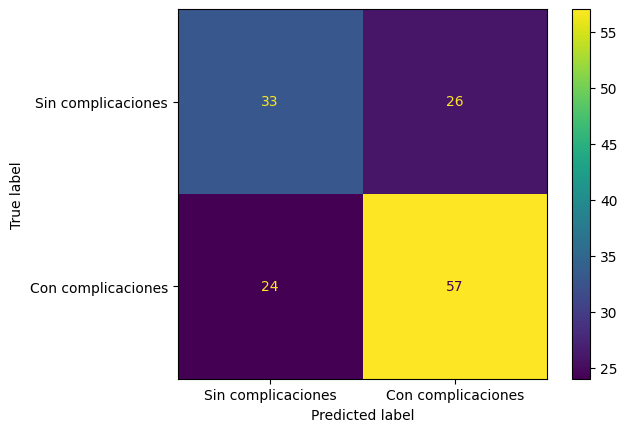

In [74]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Sin complicaciones", "Con complicaciones"])
plt.show()

## Árbol de decisión

In [75]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'class_weight': ['balanced']
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=cv, scoring='f1_weighted', verbose=3, n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("Mejor árbol de decisión: ", grid_dt.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Mejor árbol de decisión:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 20}


In [76]:
y_pred = best_dt.predict(X_val)

In [77]:
print(classification_report(y_val, y_pred,target_names=["Sin complicaciones", "Con complicaciones"]))

                    precision    recall  f1-score   support

Sin complicaciones       0.55      0.53      0.54        59
Con complicaciones       0.67      0.69      0.68        81

          accuracy                           0.62       140
         macro avg       0.61      0.61      0.61       140
      weighted avg       0.62      0.62      0.62       140



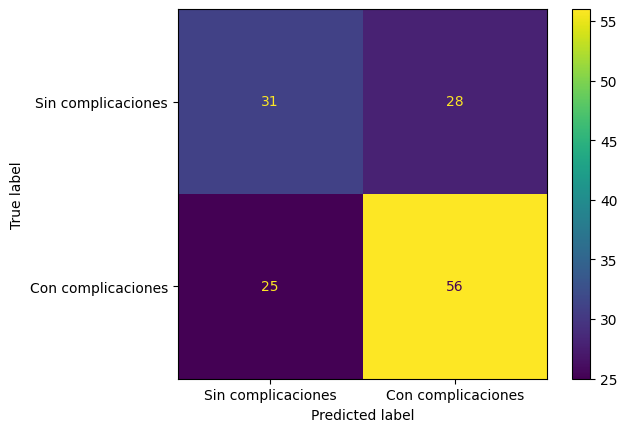

In [78]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Sin complicaciones", "Con complicaciones"])
plt.show()

## Random forest

In [79]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'class_weight': ['balanced','balanced_subsample']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=params, cv=cv, scoring='f1_weighted', verbose=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Mejor random forest: ", grid_rf.best_params_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Mejor random forest:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 20}


In [91]:
y_pred = best_rf.predict(X_val)

In [92]:
print(classification_report(y_val, y_pred,target_names=["Sin complicaciones", "Con complicaciones"]))

                    precision    recall  f1-score   support

Sin complicaciones       0.63      0.64      0.64        59
Con complicaciones       0.74      0.73      0.73        81

          accuracy                           0.69       140
         macro avg       0.69      0.69      0.69       140
      weighted avg       0.69      0.69      0.69       140



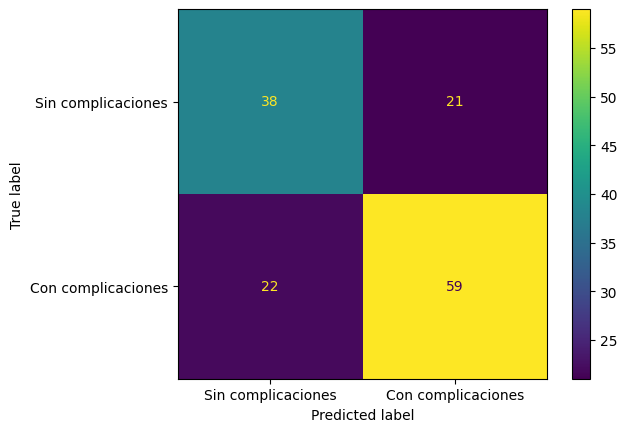

In [94]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Sin complicaciones", "Con complicaciones"])
plt.show()

## AdaBoost

In [98]:
params = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

grid_ab = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=params, cv=cv, scoring='f1_weighted', verbose=3, n_jobs=-1)
grid_ab.fit(X_train, y_train)
best_ab = grid_ab.best_estimator_
print("Mejor AdaBoost: ", grid_ab.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejor AdaBoost:  {'learning_rate': 0.5, 'n_estimators': 50}


In [99]:
y_pred = best_ab.predict(X_val)

In [100]:
print(classification_report(y_val, y_pred,target_names=["Sin complicaciones", "Con complicaciones"]))

                    precision    recall  f1-score   support

Sin complicaciones       0.64      0.58      0.61        59
Con complicaciones       0.71      0.77      0.74        81

          accuracy                           0.69       140
         macro avg       0.68      0.67      0.67       140
      weighted avg       0.68      0.69      0.68       140



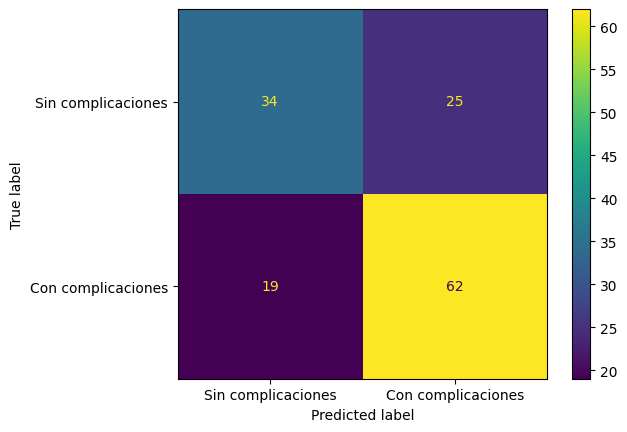

In [101]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Sin complicaciones", "Con complicaciones"])
plt.show()

## Comparación y elección del mejor modelo

Luego de entrenar los modelos, se evaluó su desempeño en un conjunto de datos que no se usó en entrenamiento.

Es importante notar que luego de imputar la variable _¿Complicación?_ esta quedó desbalanceada, por lo que tenemos más casos con complicaciones. Esto lleva a que el clasificador tenga mejor desempeño para los casos donde hay complicaciones que donde no las hay.

Los modelos evaluados fueron los siguientes:
- Regresión logística ('C': 0.01, 'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'lbfgs')
- Árbol de decisión ('class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 20)
- Random forest ('class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 20)

Las métricas obtenidas en el conjutno de validación fueron las siguientes:

|     Modelo          | Puntaje F1 (ponderado) | 
|---------------------|------------------------|
| Regresión logística |                     64%|
| Árbol de decisión   |                     62%|
| Random forest       |                     69%|
| AdaBoost            |                     68%|


# Interpretabilidad
Dado que las principales variables pueden ser de interés para el Servicio de Transplantes, vamos a revisarlo

## Shapely

In [102]:
shap.initjs()

### Random forest

In [104]:
explainer = shap.TreeExplainer(best_rf, X_train)

In [ ]:
shap_values = explainer(X_train)

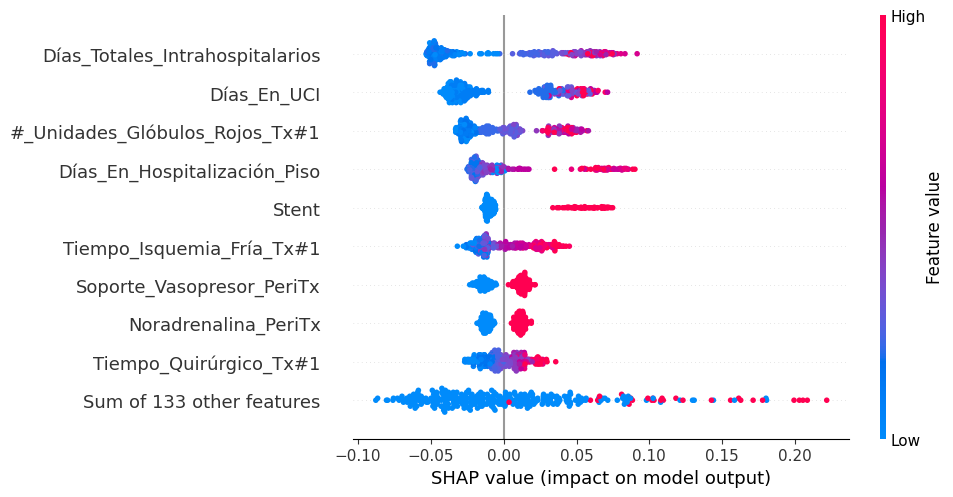

In [107]:
values = shap_values.values[:, :, 1]

expl_class = shap.Explanation(
    values=values,
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

shap.plots.beeswarm(expl_class)

Podemos ver que algunas variablers aparecen de forma consistente en los 3 modelos que analizamos. Así, tenemos que:
- A más días intrahospitalarios, sean en UCI o en habitación, se ven más probabilidades de que haya complicaciones
- Si durante la cirugía se necesitaron más uniades de glóbulos rojos o si duro más, si se se necesitó noradrenalina o soporte vasopresor, tienen más probabilidades de que haya complicaciones
- A mayor tiempo de isauemia fría, mayor probabilidad de complicaciones

# Exportar mejor modelo

In [130]:
joblib.dump(best_rf, "clasificador_complicaciones_rf.joblib")

['clasificador_complicaciones_rf.joblib']

In [174]:
feature_order = X_train.columns.tolist()

with open("feature_order.json", "w") as f:
    json.dump(feature_order, f)